In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker
import math
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import cm
import numpy.random as npr
from spyrmsd import rmsd
import os
from os import listdir
from os.path import isfile, join
import glob
import natsort 
import shutil
from pathlib import Path
from os.path import exists
import sys

save the plot? y/n: n


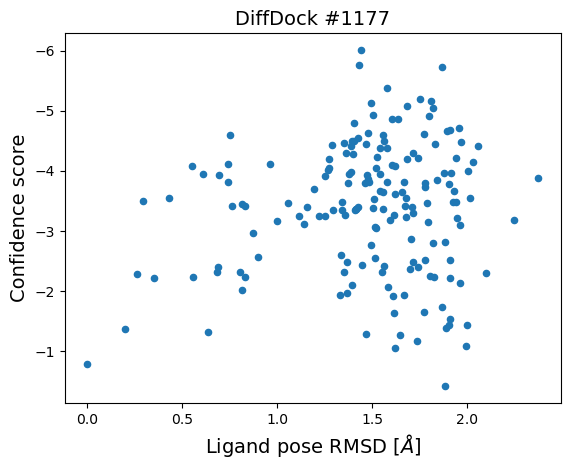

In [6]:
def sdf_files_manager():
    working_folder = input('provide a foldername: ')
    path2 = os.chdir(working_folder)
    folders = [f for f in listdir(path2)]
    names_list = []
    names_sdf_list = []
    sorted_names_sdf_nondup = []

    for root, dirs, files in os.walk(working_folder, topdown=False):
        for name in files:
            if name != '.DS_Store':
                names_list.append(name)
                if '.sdf' in name:
                    names_sdf_list.append(name)

    sorted_names_sdf = natsort.natsorted(names_sdf_list)
    for i in sorted_names_sdf:
        if i not in sorted_names_sdf_nondup:
            sorted_names_sdf_nondup.append(i)
    del sorted_names_sdf_nondup[0]

    directory_name = 'merged_sdfs'
    folder_merged_dest = os.path.join(working_folder, directory_name)
    if directory_name not in folders:
        os.mkdir(folder_merged_dest)

    count = 0
    for i in folders[1:]:
        for root, dirs, filenames in os.walk(i):
            for file in filenames:
                if file in sorted_names_sdf_nondup:
                    if exists(folder_merged_dest+'/'+file):
                        count += 1
                        break
                    else:
                        if count == 0:
                            shutil.copy(working_folder+'/'+root+'/'+file, folder_merged_dest)

    for root, dirs, filenames in os.walk(folder_merged_dest):
        files_to_transfer = natsort.natsorted(filenames)
    
    if '.txt' in ''.join(files_to_transfer[1:]):
        print('.txt output is already present! will write a text file!')
    else:
        files_to_transfer.sort(key=lambda x: x.split(("-"))[1]) #'.DS store creates itself => [1:]'

    with open('output_sdfs.txt', 'w') as f:
        for i in files_to_transfer:
            f.write("%s\n" % i)
    return folder_merged_dest
processing_folder = sdf_files_manager()

def RMSD_calculation(folder):
    path = os.chdir(folder)
    onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f)) if '.txt' not in f if '.DS_Store' not in f
                if '.sh' not in f ]
    onlyfiles.sort(key=lambda x: x.split(("-"))[1])
    ref_model = onlyfiles[1]
    RMSD_list = []
    scores_list = []
    for i in onlyfiles:
        scores_list.append(i[-9:-4:1])
        
    for i in range(len(onlyfiles)):
        test_model = onlyfiles[i]
        output_rmsd = !python3 -m spyrmsd -m {ref_model} {test_model}
        RMSD_list.append(output_rmsd)
        flat_RMSD_list = [i for sublist in RMSD_list for i in sublist]
        
    return scores_list, flat_RMSD_list
scores, rmsd_list = RMSD_calculation(processing_folder)

def score_RMSD_plot(scores, rmsd): 
    plot_df = pd.DataFrame({'rmsd':rmsd_list, 
                          'score':scores})
    plot_df = plot_df.astype(float)
    scatter = plot_df.plot(x='rmsd', y='score', kind='scatter')
    ax = scatter.axes
    ax.invert_yaxis()
    ax.set_xlabel('Ligand pose RMSD [$\AA$]', fontsize = 14)
    ax.set_ylabel('Confidence score', fontsize = 14)
    ax.set_title('DiffDock #1177', fontsize = 14)
    savefig_input = input('save the plot? y/n: ')
    if savefig_input == 'y': 
        plt.savefig(str(processing_folder)+'/'+'DiffDock #1177', 
               dpi = 300, bbox_inches='tight')
    else:
        None
    plt.show()
    
score_RMSD_plot(scores, rmsd_list)